<a id='ToP'></a>

# Talmy Lab ED Resource: Parameter Fitting of Viral Host Interactions

This is Jupyter Notebook aimed at helping incoming/new members of the lab in becoming familiar with tools and resources that make computational biology easier!

## Table of Contents

### 1. [The Model](#section1)
### 2. [Project Structure and Imports](#section2)
### 3. [Data Organization using Pandas](#section3)
### 4. [Integration with Initial Parameters](#section4)
### 5. [Markov Chain Monte Carlo](#section5)
### 6. [Jupyter Cell Magic using R](#section6)



<a id='section1'></a>

## 1. The Model
The model we will be using will have 5 infection states, as outlinelined bellow:  

$$\frac{dS}{dt} = \mu S - \phi S V$$  
$$\frac{dI_1}{dt} = \phi S V - \frac{I_1}{\tau_1}$$  
$$\frac{dI_2}{dt} = \frac{I_1}{\tau_1} - \frac{I_2}{\tau_2}$$  
$$\frac{dI_3}{dt} = \frac{I_2}{\tau_2} - \frac{I_3}{\tau_3}$$  
$$\frac{dI_4}{dt} = \frac{I_3}{\tau_3} - \frac{I_4}{\tau_4}$$  
$$\frac{dI_5}{dt} = \frac{I_4}{\tau_4} - \lambda I_5 $$  
$$\frac{dV}{dt} = \beta \lambda I_5 - \phi S V $$  

| symbol  | Description   
|----|--------------------
| $$S$$  | Host Abundance  
| $$V$$ | Viral Abundance
| $$I_i$$ | Infected Host Abundance
| $$\phi$$  | Transfer Affinity
| $$\tau_i$$  | Turnover of $I_i$
| $$\beta$$  | Burst Size
| $$\lambda$$  | Lysis Rate
| $$\mu$$  | Growth Rate

Our goal will be to find the parameter values for $\lambda$, $\phi$, all $\tau$, $\beta$ and $\mu$ that fit the data provided below.

[Top of Page](#ToP)

<a id='section2'></a>

## 2. Project Structure and Imports
One of the most important things to realize about code is that is always easier to write code than read it. Because of this, extra care needs to be taken to make sure code is well documented. One way of doing this is having predictable and intuitive patterns in project structure so that anyone is able to quickly identify where/what files are. For any given project, it is a good idea to have at least 3 directories: src (for source code), figures, and data.

For any programming language, it is always recommended to import modules ahead of time for clarity. As a rule of thumb, being overly descriptive is never a bad thing and helps legibility.

In [1]:
import numpy as np #a python computation necessity- much faster than using native python ints and lists
import pandas as pd #pandas is built on numpy and makes data management easy, but is a little slower than numpy
from scipy.integrate import odeint #scipy fortran wrapper for integration
import pylab
from src.batch_fitting_module import model_5infection,integrate,do_fitting #fuctions written for this notebook

<a id='section3'></a>

## 3. Data Organization using Pandas
Pandas is an incredibly powerful module. Pandas uses [DataFrames](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), an datastructure that makes managing data **much** easier. The power of DataFrames is in indexing, allowing users easy and computationally inexpensive ways to accessing data in dataframes, especially when they may have thousands of entries. The one caveat is that pandas’ DataFrames are [slower than the arrays used by numpy](https://zerowithdot.com/python-numpy-and-pandas-performance/), therefore, it is recommended that pandas be used when clarity is important. Much of pandas’ code relies on numpy, therefore, using the two interchangeably is very doable.  
[Top of Page](#ToP)

In [2]:
# host sampling times
htimes =  np.r_[[0. , 0.2, 0.3, 0.5, 0.7, 0.9, 1. , 1.2, 1.3, 1.5, 1.7, 1.8, 2. ,
        2.2, 2.3, 2.5, 2.8, 3. ]]
# virus sampling times
vtimes = np.r_[[0. , 0.2, 0.3, 0.5, 0.7, 0.9, 0.9, 1. , 1.2, 1.3, 1.5, 1.7, 1.8,
        2. , 2.2, 2.3, 2.5, 2.8, 3. ]]
# host abundances
hms = np.r_[[5236900., 5768400., 5835000., 4846200., 4702100., 4283600.,
        3675000., 3466700., 3385700., 2143500., 1682400., 1179200.,
         971320.,  890380.,  957390.,  791980.,  734840.,  655160.]]
# virus abundances
vms = np.r_[[1.0981e+07, 1.2959e+07, 1.3273e+07, 1.7914e+07, 1.5899e+07,
        1.3881e+07, 1.5545e+07, 1.4527e+07, 1.2516e+07, 3.2464e+07,
        2.2129e+07, 3.2426e+07, 3.9063e+07, 6.5668e+07, 3.7031e+07,
        6.6297e+07, 9.1902e+07, 1.3446e+08, 1.6306e+08]]
# host uncertainty
hss = np.r_[[750750.0, 950680.0, 614550.0, 1024690.0, 1066300.0, 1319600.0,
        1890100.0, 1912950.0, 1837700.0, 1077450.0, 592060.0, 538460.0,
        422250.0, 232770.0, 105898.21, 232205.0, 200460.0, 306570.0]]
# virus uncertainty
vss = np.r_[[656690.0, 2987300.0, 3480600.0, 3981250.0, 4815700.0, 3985500.0,
        3491900.0, 5474350.0, 6314200.0, 22926000.0, 13453500.0,
        22594500.0, 2323200.0, 19773000.0, 5151000.0, 3986300.0, 1657250.0,
        11629500.0, 35377000.0]]
#Let's organize our data into a dataframe. Notice that pandas accepts numpy arrays!
virus = pd.DataFrame({'time':vtimes,'abundance':vms,'uncertainty':vss,'organism':'virus'})
host = pd.DataFrame({'time':htimes,'abundance':hms,'uncertainty':hss,'organism':'host'})
df = pd.concat([virus,host])
df = df.set_index(['organism']) #set the index, makes data access *much* easier
df

,time,abundance,uncertainty
organism,,,
virus,0.0,10981000.0,656690.00
virus,0.2,12959000.0,2987300.00
virus,0.3,13273000.0,3480600.00
virus,0.5,17914000.0,3981250.00
virus,0.7,15899000.0,4815700.00
virus,0.9,13881000.0,3985500.00
virus,0.9,15545000.0,3491900.00
virus,1.0,14527000.0,5474350.00
virus,1.2,12516000.0,6314200.00


<a id='section4'></a>

# 4. Integration with Initial Parameters

To start our parameter fitting, we first need to pick initial parameter set. We will use scipy’s [odeint](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html) function to perform the integration. If you want to check the implementation, see src/batch_fitting_module.py

[Top of Page](#ToP)

In [3]:
parameters = {'host growth rate':1e-6,
              'transfer affinity':1e-6,
              'I1 turnover':0.2,
              'I2 turnover':0.2,
              'I3 turnover':0.2,
              'I4 turnover':0.2,
              'lysis rate':1.0,
              'burst size':50}
# time array and initial conditions
param_init = tuple([parameters[el] for el in parameters]) #we need a tuple of values
days = max(np.amax(df.loc['host']['time']),np.amax(df.loc['virus']['time'])) #find the maximum days from all times
times = np.arange(0, days, 900.0 / 86400.0)
#getting the initial value at time 0
inits = np.r_[[df.loc['host'].iloc[0]['abundance'],0,0,0,0,0,df.loc['virus'].iloc[0]['abundance']]]
h,v = integrate(df,model_5infection,inits,times,param_init)

[]

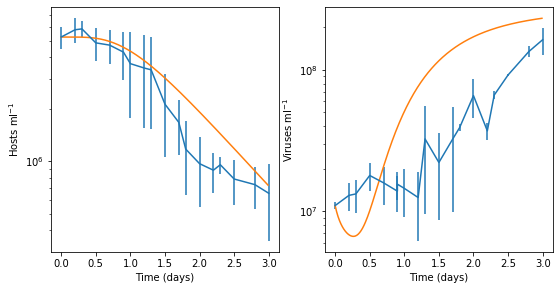

In [4]:
f,ax = pylab.subplots(1,2,figsize=[9,4.5])
ax[0].errorbar(df.loc['host']['time'],df.loc['host']['abundance'],yerr=df.loc['host']['uncertainty'])
ax[1].errorbar(df.loc['virus']['time'],df.loc['virus']['abundance'],yerr=df.loc['virus']['uncertainty'])
ax[0].plot(times,h,label='prior')
ax[1].plot(times,v)
ax[0].set_xlabel('Time (days)')
ax[1].set_xlabel('Time (days)')
ax[0].set_ylabel('Hosts ml$^{-1}$')
ax[1].set_ylabel('Viruses ml$^{-1}$')
ax[0].semilogy()
ax[1].semilogy()

<a id='section5'></a>

## 5. Markov Chain Monte Carlo
Our inital parameter choice caused our fits to be less than idea. To optimize our fits, we will do a fitting protocol where we draw parameters at random, where each random draw will be evaluated with a goodness of fit test. If an iteration has a better fit, those parameters are kept, however, if the randomly chosen parameters perform poorer, they old parameters are kept.

**Add explaination of error function?**

[Top of Page](#ToP)

In [5]:
pall,likelihoods,iterations = do_fitting(df,model_5infection,inits,times,parameters,nits=1000,pits=100,burnin=500)

a priori error 52.113880367242174
iteration; error; acceptance ratio
100 ; 16.85 ; 0.0
200 ; 11.82 ; 0.0
300 ; 14.82 ; 0.0
400 ; 13.58 ; 0.0
500 ; 13.04 ; 0.0
600 ; 12.48 ; 0.74
700 ; 13.61 ; 0.8
800 ; 15.77 ; 0.72
900 ; 12.88 ; 0.78
 
Median parameters
host growth rate = 1.1249484788908488e-07
transfer affinity = 1.7082880299976923e-06
I1 turnover = 0.7227102054059852
I2 turnover = 0.07464321242706744
I3 turnover = 0.22839794509234698
I4 turnover = 0.087742235622563
lysis rate = 2.1898635220228733
burst size = 15.11121409447718
 
Standard deviations
host growth rate std = 2.525081070385612e-08
transfer affinity std = 1.1007459743181378e-06
I1 turnover std = 0.19195352977124017
I2 turnover std = 0.04574535648129068
I3 turnover std = 0.04046010681254641
I4 turnover std = 0.0769406357307209
lysis rate std = 0.8205867542224141
burst size std = 2.376799434106918
 


In [6]:
pall

,host growth rate,transfer affinity,I1 turnover,I2 turnover,I3 turnover,I4 turnover,lysis rate,burst size
0,1.224721e-07,7.856043e-07,0.479689,0.252296,0.141908,0.130439,1.753491,11.749353
1,1.237700e-07,7.649078e-07,0.487767,0.243850,0.142079,0.127102,1.698882,12.353849
2,1.391312e-07,7.332811e-07,0.479615,0.222278,0.150632,0.113997,1.659392,12.410345
3,1.316867e-07,7.184935e-07,0.472922,0.227677,0.140728,0.112749,1.650168,11.638457
4,1.325027e-07,6.653913e-07,0.468973,0.236652,0.144573,0.103884,1.689291,11.543182
...,...,...,...,...,...,...,...,...
372,1.224584e-07,3.496924e-06,1.000499,0.045077,0.214494,0.024356,3.183833,10.737464
373,1.202186e-07,3.310358e-06,1.040765,0.042351,0.215489,0.026366,3.087034,11.230297
374,1.176700e-07,3.245847e-06,1.022945,0.041213,0.217142,0.024766,3.016551,11.009304
375,1.209796e-07,3.355814e-06,0.945658,0.041842,0.214510,0.024068,3.149166,11.097733


[]

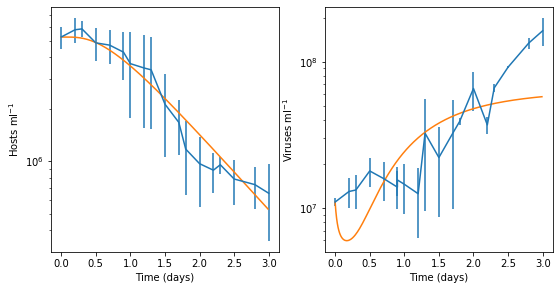

In [7]:
h,v = integrate(df,model_5infection,inits,times,pall.iloc[-1])
f,ax = pylab.subplots(1,2,figsize=[9,4.5])
ax[0].errorbar(df.loc['host']['time'],df.loc['host']['abundance'],yerr=df.loc['host']['uncertainty'])
ax[1].errorbar(df.loc['virus']['time'],df.loc['virus']['abundance'],yerr=df.loc['virus']['uncertainty'])
ax[0].plot(times,h,label='prior')
ax[1].plot(times,v)
ax[0].set_xlabel('Time (days)')
ax[1].set_xlabel('Time (days)')
ax[0].set_ylabel('Hosts ml$^{-1}$')
ax[1].set_ylabel('Viruses ml$^{-1}$')
ax[0].semilogy()
ax[1].semilogy()

<a id='section6'></a>

# 6.Jupyter Cell Magic using R
One of the benefits of a jupyter notebook is the ability to swap between programing languages, namely python to R. In the following example, the pandas dataframe will be automatically converted to an R dataframe to be plotted with ggplot2. This way, you can use the clarity and tractibility of python and still have access to the vast libraries of R

In order for this to work, we will need to make a very big dataframe of all of our data

[Top of Page](#ToP)

In [8]:
#this allows us to seemlessly swap to R from within our python notebook!
%load_ext rpy2.ipython
########################

predh = pd.DataFrame({'time':times,'abundance':h,'organism':'mod-host'})
predv = pd.DataFrame({'time':times,'abundance':v,'organism':'mod-virus'})
#R is dumb and cannot do the indexing pandas can, so we resent the index
df_all = pd.concat([df.reset_index(),predh,predv])
df_all

/home/spiridon/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


,organism,time,abundance,uncertainty
0,virus,0.000000,1.098100e+07,656690.0
1,virus,0.200000,1.295900e+07,2987300.0
2,virus,0.300000,1.327300e+07,3480600.0
3,virus,0.500000,1.791400e+07,3981250.0
4,virus,0.700000,1.589900e+07,4815700.0
...,...,...,...,...
283,mod-virus,2.947917,5.744122e+07,NaN
284,mod-virus,2.958333,5.750515e+07,NaN
285,mod-virus,2.968750,5.756841e+07,NaN
286,mod-virus,2.979167,5.763102e+07,NaN


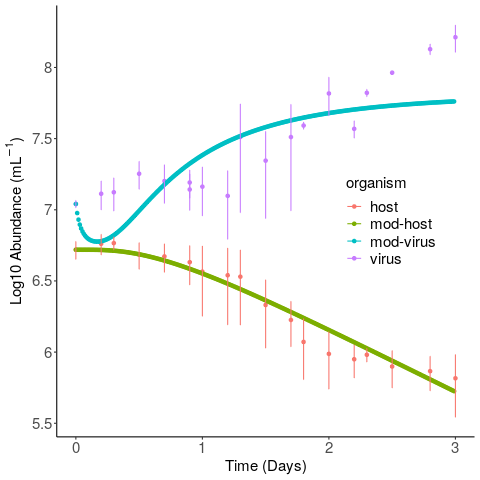

In [9]:
%%R -i df_all
library('ggplot2')

axis_text_size=15

plt <- ggplot(data=df_all,aes(x=time,y=abundance,color=organism))+
    geom_point()+
    geom_errorbar(aes(ymin=abundance-uncertainty, ymax=abundance+uncertainty))+
    scale_y_log10(
    breaks = scales::trans_breaks("log10", function(x) {10^x}),
    labels = scales::trans_format("log10", scales::math_format(.x)))+
    theme_bw()+
    labs(x="Time (Days)",y=bquote('Log10 Abundance ('*'mL'^-1*')'))+
    theme(panel.border = element_blank(), 
          panel.grid.minor = element_blank(),
          panel.grid.major = element_blank(),
          axis.line = element_line(color="black"),
          legend.position = c(0.8,0.5),
          axis.text = element_text(size=axis_text_size),
          axis.title = element_text(size=axis_text_size),
          legend.title=element_text(size=axis_text_size),
          legend.text=element_text(size=axis_text_size))
print(plt)